In [14]:
import os
import sys
# script_path = "../Libs/"
# sys.path.append(os.path.abspath(script_path))
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pylab
import librosa.display
import scipy.io.wavfile as wavio
import scipy.io as spio
from mel_utils import get_mel_spectrum, powspec, get_filterbank_from_midfreqs, framesig, genICFilterMatrix
# from mel_utils import get_filterbanks
from scipy import signal # audio processing
from scipy.fftpack import dct
import librosa # library for audio
from mel_utils import *
import skimage
from tqdm import tqdm

## This Code is to demostrate how to vistualizing speech data for analyzing speech

In [15]:
# !pip install scikit-image

In [16]:
"""
very basic spectrogram drawing
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('y.wav')

# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectrogram of a wav file with piano music')

plot.plot(signalData)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)

plot.xlabel('Time')

plot.ylabel('Frequency')

plot.show()
"""

"\nvery basic spectrogram drawing\n# Read the wav file (mono)\n\nsamplingFrequency, signalData = wavfile.read('y.wav')\n\n# Plot the signal read from wav file\n\nplot.subplot(211)\n\nplot.title('Spectrogram of a wav file with piano music')\n\nplot.plot(signalData)\n\nplot.xlabel('Sample')\n\nplot.ylabel('Amplitude')\n\nplot.subplot(212)\n\nplot.specgram(signalData,Fs=samplingFrequency)\n\nplot.xlabel('Time')\n\nplot.ylabel('Frequency')\n\nplot.show()\n"

In [17]:
def log_specgram(audio, sample_rate, window_size=10, 
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio, fs=sample_rate,
                                    window='hann', nperseg=nperseg, noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

def audio_to_data(path):
    # we take a single path and convert it into data
    sample_rate, audio = wavfile.read(path)
    spectrogram = log_specgram(audio, sample_rate, 10, 0)
    return spectrogram.T

In [18]:
"""
sig, fs = librosa.load('path_to_my_wav_file')   
# make pictures name 
save_path = 'test.jpg'

pylab.axis('off') # no axis
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
S = librosa.feature.melspectrogram(y=sig, sr=fs)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
pylab.close()
"""

"\nsig, fs = librosa.load('path_to_my_wav_file')   \n# make pictures name \nsave_path = 'test.jpg'\n\npylab.axis('off') # no axis\npylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge\nS = librosa.feature.melspectrogram(y=sig, sr=fs)\nlibrosa.display.specshow(librosa.power_to_db(S, ref=np.max))\npylab.savefig(save_path, bbox_inches=None, pad_inches=0)\npylab.close()\n"

In [19]:
test_wav_file = "./compared_wav/MELandIC_Bandpass_Tone_0728b.wav"

In [20]:
def custom_matrix_multiply(A, B):
    """
    to-do: modifying to more general version
    """
    len_of_A_row = A.shape[0]
    len_of_A_col = A.shape[1]
    tmp_row_list = []
    total_row_list = []
    res = [None] * 10
    counter = 0
    for r_idx in range(len_of_A_row):
        for ele_idx in range(len_of_A_col):
            res[0] = A[r_idx][ele_idx] * B[0][ele_idx]
            res[1] = A[r_idx][ele_idx] * B[1][ele_idx]
            res[2] = A[r_idx][ele_idx] * B[2][ele_idx]
            res[3] = A[r_idx][ele_idx] * B[3][ele_idx]
            res[4] = A[r_idx][ele_idx] * B[4][ele_idx]
            res[5] = A[r_idx][ele_idx] * B[5][ele_idx]
            res[6] = A[r_idx][ele_idx] * B[6][ele_idx]
            res[7] = A[r_idx][ele_idx] * B[7][ele_idx]
            res[8] = A[r_idx][ele_idx] * B[8][ele_idx]
            res[9] = A[r_idx][ele_idx] * B[9][ele_idx]
            sum_res = sum(res)
            tmp_row_list.append(sum_res)
            del res
            res =  [None] * 10
            counter += 1
#         print("counter is {}".format(counter))
        counter = 0
        total_row_list.append(tmp_row_list)
        del tmp_row_list
        tmp_row_list=[]
#     print("total_row_list length is {}".format(len(total_row_list)))
    ret_array = np.array(total_row_list)
#     print("ret_array shape is {}".format(ret_array.shape))
    return ret_array
    

In [21]:
def norm_signal(frames):
    return frames/np.max(frames)

def norm_int16_signal(frames):
    return frames/32768

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def normalized_fb(fb):
    fb -= (np.mean(fb, axis=0) + 1e-8)
    return fb

def get_scale_for_Y_axis():
    y_scale_points = 513
    factor = 8000/512
    y_scales = [None] * 513
    for i in range(y_scale_points):
        scale = i * factor
        y_scales[i]=scale
    y_scale_ary = np.array(y_scales)
    return y_scale_ary

In [22]:
def test_custom_matrix_multiply(wavfile):
    sr, sig = wavio.read(wavfile)
    sig = norm_int16_signal(sig)
    framed_sig = framesig(sig,400,400)
    sample_len = 513
    mid_banks = [0.0,195.0985245,251.8401972,312.1788118,376.342384,
                 444.5733837,517.1296516,1550.447293,2554.078667,
                 3461.030019,4620.759758,8000.0]
    melfb = get_filterbank_from_midfreqs(midFreqs=mid_banks)
    print(melfb.shape)
    middleFreq = [16, 20, 26, 36, 48, 60, 80, 101, 256, 353]
    inband = 4
    bandnum_ = 10
    y_length_=513
    icfb = genICFilterMatrix(bandnum=10,y_length=513,mid_freq_matrix=middleFreq)
    sig_fft = magspec(framed_sig,1024)
    sig_powspec = powspec(framed_sig,1024)
    sig_powspec = np.split(sig_powspec,[0,sample_len],axis=1)[1]
#     print(sig_powspec[0][0:8])
#     print("**************************************")
    plt.figure(figsize=(30,15))
    plt.subplot(111)
    librosa.display.specshow(librosa.power_to_db(sig_powspec.T, ref=np.max)
                             ,y_axis='hz', sr=16000, x_axis='time')
    
    sig_mel_spectrogram = custom_matrix_multiply(sig_powspec, melfb) #np.dot(sig_powspec.T,melfb.T)
#     print(sig_mel_spectrogram[0][0:8])
    sig_icfb_spectrogram = custom_matrix_multiply(sig_powspec, icfb)

[   0.         195.0985245  251.8401972  312.1788118  376.342384
  444.5733837  517.1296516 1550.447293  2554.078667  3461.030019
 4620.759758  8000.       ]
12
(10, 513)


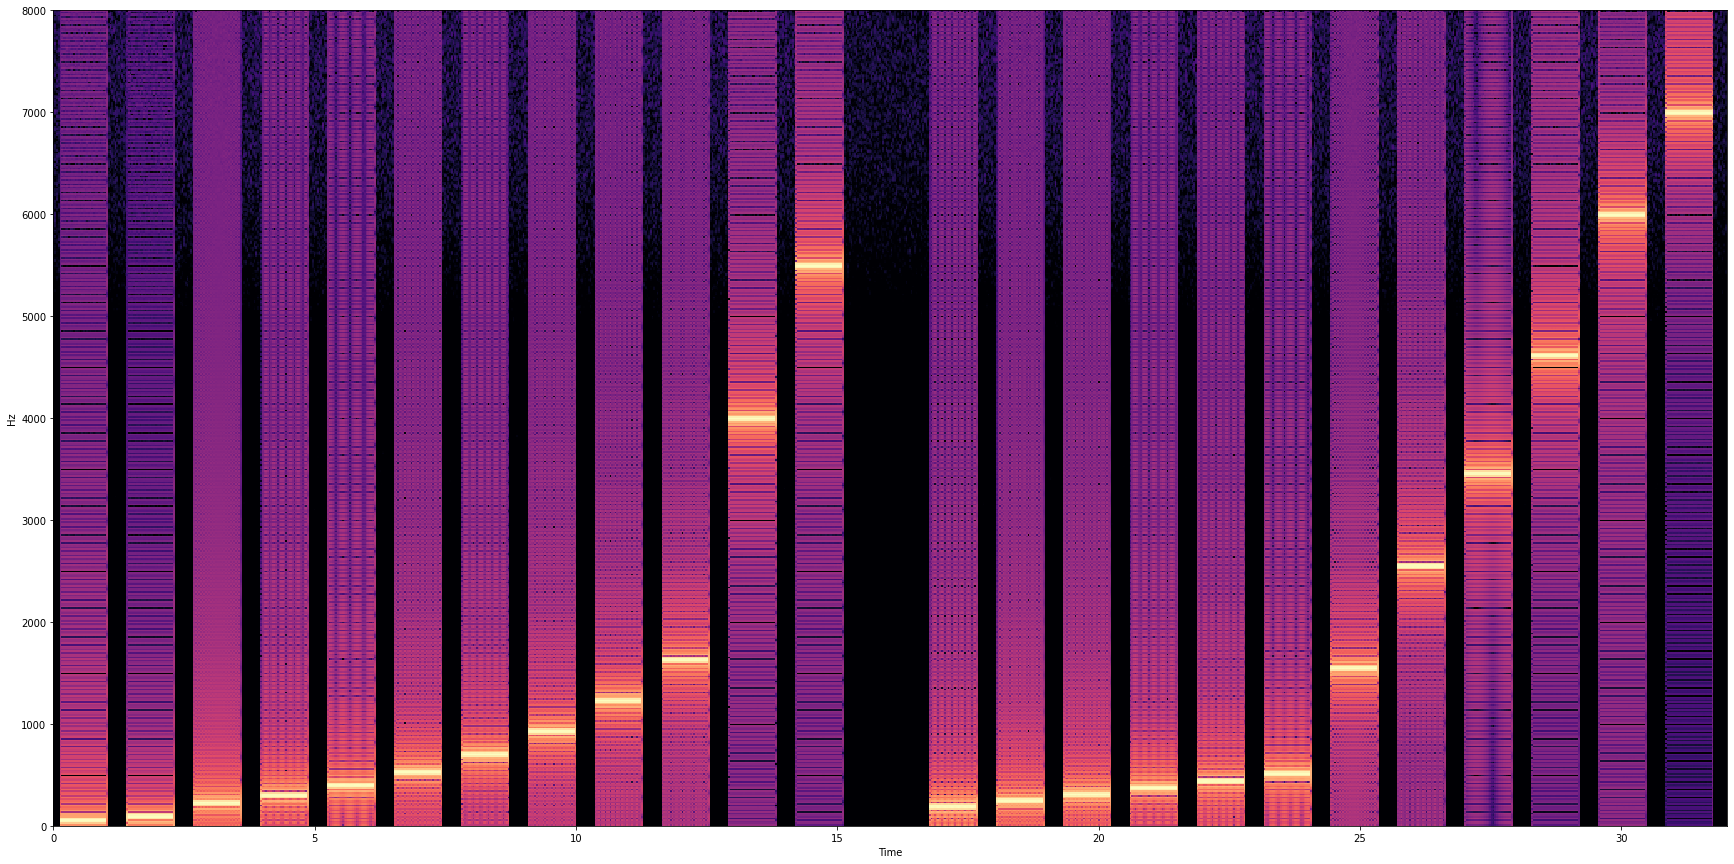

In [23]:
test_custom_matrix_multiply(test_wav_file)

In [26]:
def test_custom_matrix_multiply_v2(wavfile):
    debug_info_path = "./debug_info/"
    if not os.path.exists(debug_info_path):
        os.mkdir(debug_info_path)
    sr, sig = wavio.read(wavfile)
    sig = norm_int16_signal(sig)
    framed_sig = framesig(sig,400,400)
    sample_len = 513
    mid_banks = [0.0,195.0985245,251.8401972,312.1788118,376.342384,
                 444.5733837,517.1296516,1550.447293,2554.078667,
                 3461.030019,4620.759758,8000.0]
    melfb = spio.loadmat("./melfb_output/melfb_10.mat")["melfb10"]
#     print(melfb.shape)
#     return
    middleFreq = [16, 20, 26, 36, 48, 60, 80, 101, 256, 353]
    inband = 4
    bandnum_ = 10
    y_length_=513
    icfb = genICFilterMatrix(bandnum=10,y_length=513,mid_freq_matrix=middleFreq)
    sig_fft = magspec(framed_sig,1024)
    
    sig_powspec = powspec(framed_sig,1024)
    sig_powspec = np.split(sig_powspec,[0,sample_len],axis=1)[1]
#     print(sig_powspec[0][0:8])
#     print("**************************************")
    plt.figure(figsize=(30,15))
#     plt.subplot(311)
#     librosa.display.specshow(librosa.power_to_db(sig_powspec.T, ref=np.max)
#                              ,y_axis='hz', sr=16000, x_axis='time')
    
    sig_mel_spectrogram = custom_matrix_multiply(sig_powspec, melfb) #np.dot(sig_powspec.T,melfb.T)
    plt.subplot(211)
    librosa.display.specshow(librosa.power_to_db(sig_mel_spectrogram.T, ref=np.max)
                             ,y_axis='hz', sr=16000, x_axis='time')
    debug_dict = {"melfb":melfb, "sigfft":sig_fft, "melspectrogram":sig_mel_spectrogram}
    spio.savemat(debug_info_path+"debuginfo.mat",debug_dict, oned_as='col')
    plt.subplot(212)
    sig_icfb_spectrogram = custom_matrix_multiply(sig_powspec, icfb)
    librosa.display.specshow(librosa.power_to_db(sig_icfb_spectrogram.T, ref=np.max)
                             ,y_axis='hz', sr=16000, x_axis='time')
    

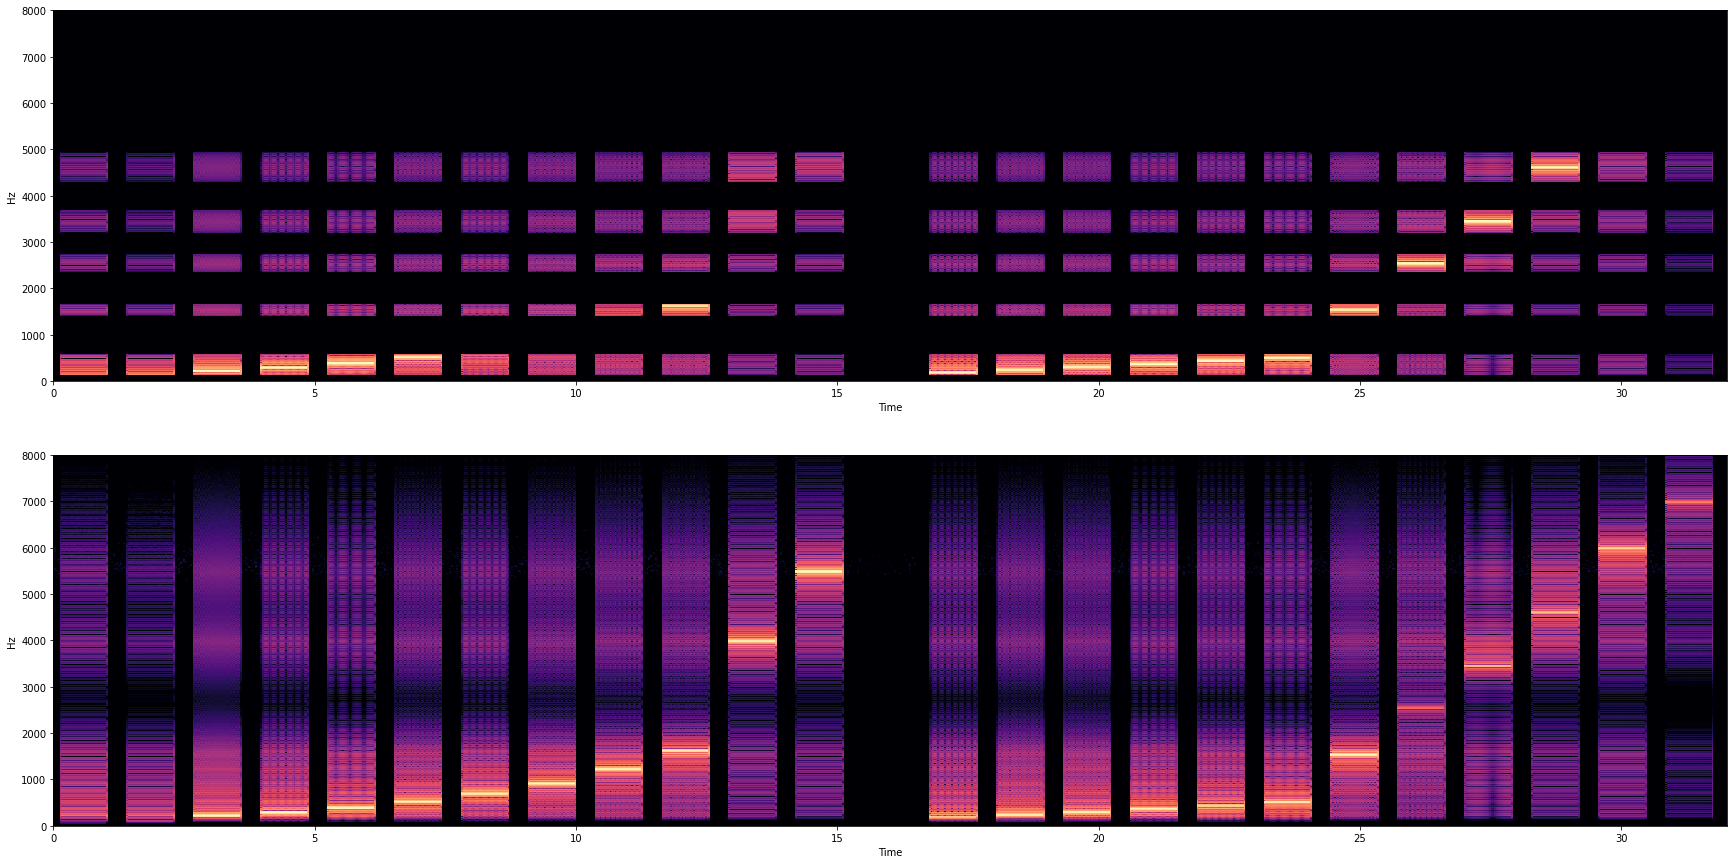

In [27]:
test_custom_matrix_multiply_v2(test_wav_file)

In [20]:
ary = np.array([4.+0.j ,0.62753559-2.76128201j])
ary**2
1.36068472-0.22613495j**2
# 0.62753559*0.62753559
# -2.76128201*-2.76128201

(1.4118217356115026+0j)

In [124]:
def draw_mel_spectrogram_with_custom_multiply(wavfile):
    sr, sig = wavio.read(wavfile)
    framed_sig = framesig(sig,400,400)
    print("length of framed_sig is {}".format(len(framed_sig)))
    sample_len = 513
    mid_banks = [0.0,195.0985245,251.8401972,312.1788118,376.342384,
                 444.5733837,517.1296516,1550.447293,2554.078667,
                 3461.030019,4620.759758,8000.0]
    melfb = get_filterbank_from_midfreqs(midFreqs=mid_banks)
    middleFreq = [16, 20, 26, 36, 48, 60, 80, 101, 256, 353]
    inband = 4
    bandnum_ = 10
    y_length_=513
    icfb = genICFilterMatrix(bandnum=10,y_length=513,mid_freq_matrix=middleFreq)
    sig_powspec = powspec(framed_sig,1024)
    sig_powspec = np.split(sig_powspec.T,[0,sample_len],axis=0)[1]
#     librosa.display.specshow(librosa.power_to_db(sig_powspec, ref=np.max),y_axis='linear', fmax=8000, x_axis='time')
    print(melfb.shape)
    print(sig_powspec.shape)
    sig_mel_spectrogram = custom_matrix_multiply(sig_powspec.T, icfb)
    print(sig_mel_spectrogram.shape)
    librosa.display.specshow(librosa.power_to_db(sig_mel_spectrogram.T, ref=np.max),y_axis='linear', fmax=8000, x_axis='time')

In [2]:
# draw_mel_spectrogram_with_custom_multiply(test_wav_file)

In [69]:
def run_draw_melspecg_in_10_band(wavfile):
    sr, sig = wavio.read(wavfile)
    framed_sig = framesig(sig,400,400)
    print("length of framed_sig is {}".format(len(framed_sig)))
    sample_len = 513
    mid_banks = [0.0,195.0985245,251.8401972,312.1788118,376.342384,
                 444.5733837,517.1296516,1550.447293,2554.078667,
                 3461.030019,4620.759758,8000.0]
    melfb = get_filterbank_from_midfreqs(midFreqs=mid_banks)
#     melfb = get_filterbanks()
    sig_powspec = powspec(framed_sig,1024)
    sig_powspec = np.split(sig_powspec.T,[0,sample_len],axis=0)[1]
    print(melfb.shape)
    print(sig_powspec.shape)
    sig_specgram = np.dot(sig_powspec.T,melfb.T)
#     sig_specgram = normalized_fb(sig_specgram)
    print(sig_specgram)
    librosa.display.specshow(librosa.power_to_db(sig_specgram, ref=np.max),y_axis='linear', fmax=8000, x_axis='time')
#     log_specgram = 10*np.log(sig_specgram+1e-9)

In [18]:
def getMelSpectrogram(signal, samplerate):
    S_ = librosa.feature.melspectrogram(y=signal, sr=samplerate, n_fft=1024, win_length=400, hop_length=400)
    return S_

In [17]:
def run_librosa_draw_melspectrogram(wavfile):
    sig, fs = librosa.load(wavfile)   
    # make pictures name 
    save_path = './test.jpg'
#     pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = getMelSpectrogram(sig,fs)
    print(S.shape)
#     plt.show(S)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max),y_axis='mel', fmax=9500, x_axis='time')
#     pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
#     pylab.close()

(128, 552)


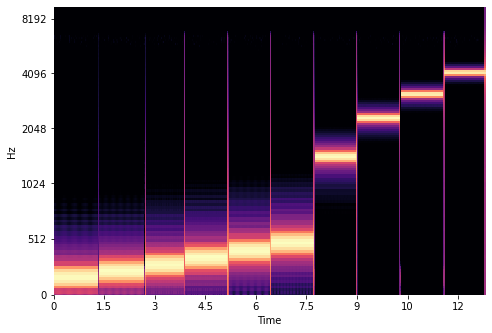

In [19]:
run_librosa_draw_melspectrogram(test_wav_file)

In [26]:
def run_draw_icfilter_spectrogram(wavfile):
    middleFreq = [16, 20, 26, 36, 48, 60, 80, 101, 256, 353]
    inband = 4
    bandnum_ = 10
    y_length_=513
    ic_fb = genICFilterMatrix(bandnum=10,y_length=513,mid_freq_matrix=middleFreq)
    sr, sig = wavio.read(wavfile)
    print("lenght of original sig is {}".format(len(sig)))
    framed_sig = framesig(sig,400,400)
    print("lenght of framed sig is {}".format(len(framed_sig)))
    sig_powspec = powspec(framed_sig,1024)
    sample_len = 513
    sig_powspec = np.split(sig_powspec.T,[0,sample_len],axis=0)[1]
    print(ic_fb.shape)
    print(sig_powspec.shape)
    sig_specgram = np.dot(sig_powspec.T,ic_fb.T)
    librosa.display.specshow(librosa.power_to_db(sig_specgram, ref=np.max),y_axis='linear', fmax=8000, x_axis='time')

In [3]:
# run_draw_icfilter_spectrogram(test_wav_file)

length of framed_sig is 400
[   0.         195.0985245  251.8401972  312.1788118  376.342384
  444.5733837  517.1296516 1550.447293  2554.078667  3461.030019
 4620.759758  8000.       ]
12
(10, 513)
(513, 400)
[[ 3.05929757e+09  2.41026541e+08 -3.34298721e+08 ... -4.24723346e+08
  -4.24171625e+08 -4.07694783e+08]
 [ 2.84316375e+09  2.90848850e+08 -3.12784868e+08 ... -4.21652114e+08
  -4.22405495e+08 -4.05525244e+08]
 [ 2.85974698e+09  2.87033398e+08 -3.14435260e+08 ... -4.21887798e+08
  -4.22541536e+08 -4.05693841e+08]
 ...
 [-3.99439740e+08 -4.20622825e+08 -3.76286585e+08 ... -4.22230045e+08
  -3.66747056e+08  3.80728183e+09]
 [-3.99439714e+08 -4.20622814e+08 -3.76286547e+08 ... -4.22229989e+08
  -3.66747260e+08  3.80725466e+09]
 [-3.99439728e+08 -4.20622811e+08 -3.76286481e+08 ... -4.22228333e+08
  -3.66743327e+08  3.80720260e+09]]


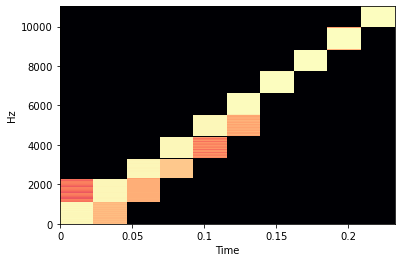

In [70]:
run_draw_melspecg_in_10_band(test_wav_file)

In [11]:
def run_drawing_3(wavfile):
    sr, sig = wavio.read(wavfile)
    framed_sig = framesig(sig,400,400)
    print("length of framed_sig is {}".format(len(framed_sig)))
    sample_len = 513
    mid_banks = [0.0,195.0985245,251.8401972,312.1788118,376.342384,
                 444.5733837,517.1296516,1550.447293,2554.078667,
                 3461.030019,4620.759758,8000.0]
    melfb = get_filterbank_from_midfreqs(midFreqs=mid_banks)
    sig_powspec = powspec(framed_sig,1024)
    sig_powspec = np.split(sig_powspec.T,[0,sample_len],axis=0)[1]
    print(melfb.shape)
    print(sig_powspec.shape)
    
    sig_specgram = np.dot(melfb,sig_powspec)
    log_specgram = 10*np.log(sig_specgram)
    librosa.display.specshow(librosa.power_to_db(sig_powspec, ref=np.max),y_axis='mel', fmax=9500, x_axis='time')
    plt.figure(figsize=(20,8))
    plt.subplot(211)
    plt.title('spectrogram of wav file')
    plt.title('wavform and spectrogram of wav file')
    plt.plot(sig)
    plt.xlabel('Sample Points')
    plt.ylabel('Amplitude')
    plt.subplot(212)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.imshow(log_specgram)

In [12]:
run_drawing_3(test_wav_file)

NameError: name 'wavio' is not defined

In [13]:
def run_drawing(wavfile):
    sr, sig = wavio.read(wavfile)
    plt.figure(figsize=(14,10))
    plt.subplot(211)
    plt.title('wavform and spectrogram of wav file')
    plt.plot(sig)
    plt.xlabel('Sample Points')
    plt.ylabel('Amplitude')
    plt.subplot(212)
    plt.specgram(sig,Fs=sr)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
# test_wav = "./raw_wav/Flipped.dat.wav"
run_drawing(test_wav_file)

NameError: name 'wavio' is not defined

In [ ]:
# if __name__ == "__main__":
#     run_drawing()